In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

#import plotnine
#from plotnine import *

In [2]:
# 경로 설정
data_path = '/Data2/hm22/New/data'
saved_path = '/Data2/hm22/New/code/saved'
output_path = '/Data2/hm22/New/code/submission'

In [3]:
# 데이터 불러오기 
history = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
watch = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
buy = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8') 
search = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')
profile = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')

In [4]:
hd = history.copy()
wd = watch.copy()
bd = buy.copy()
sd = search.copy()
pd = profile.copy()

In [5]:
print('hd 데이터(중복 제거 전) : ', hd.shape)
print('wd 데이터(중복 제거 전) : ', wd.shape)

hd 데이터(중복 제거 전) :  (1005651, 8)
wd 데이터(중복 제거 전) :  (892794, 8)


#### 1. 중복 데이터 제거

In [6]:
# 중복행 확인
hd[hd.duplicated()] # 시청시작 데이터

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
517,5,20220421082427,20220421082957,MKID003,92,NaN,N,N
519,5,20220421082427,20220421085009,MKID003,174,NaN,N,N
521,5,20220421082427,20220421090237,MKID003,201,NaN,N,N
523,5,20220421082427,20220421090332,MKID003,187,NaN,N,N
525,5,20220421082427,20220421090449,MKID003,305,NaN,N,N
...,...,...,...,...,...,...,...,...
1004498,32908,20220420203843,20220420204139,MKID003,6458,NaN,N,N
1005467,33015,20220424194027,20220424194036,MKID003,416,NaN,Y,N
1005469,33015,20220424194027,20220424194091,MKID003,175,NaN,N,Y
1005471,33015,20220424195608,20220424195612,MKID003,57,NaN,N,N


In [7]:
wd[wd.duplicated()] # 시청종료 데이터

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
507,5,20220421082427,20220421082953,MKID049,298,307,309,1
509,5,20220421082427,20220421085005,MKID049,92,1207,1207,1
511,5,20220421082427,20220421090233,MKID049,174,744,745,1
513,5,20220421082427,20220421090327,MKID049,201,50,50,1
515,5,20220421082427,20220421090443,MKID049,187,70,70,1
...,...,...,...,...,...,...,...,...
892571,33016,20220424194881,20220424195327,MKID049,5873,94,94,1
892573,33016,20220424194881,20220424195543,MKID049,5874,94,94,1
892575,33016,20220424194881,20220424195570,MKID049,5874,50,94,0
892577,33016,20220424194881,20220424195683,MKID049,4598,34,95,0


In [8]:
# 중복행 제거
hd = hd[~hd.duplicated()]
print('hd 데이터(중복 제거 후) : ', hd.shape)

wd = wd[~wd.duplicated()]
print('wd 데이터(중복 제거 후) : ', wd.shape)

hd 데이터(중복 제거 후) :  (899273, 8)
wd 데이터(중복 제거 후) :  (800740, 8)


#### 2. 결측치 제거  ( 각자 다른 방법으로 시도)

In [9]:
# 결측치 확인
hd.isnull().sum().to_frame()

,0
profile_id,0
ss_id,0
log_time,0
act_target_dtl,0
album_id,0
payment,840080
continuous_play,0
short_trailer,0


In [10]:
wd.isnull().sum().to_frame()

,0
profile_id,0
ss_id,0
log_time,0
act_target_dtl,0
album_id,0
watch_time,0
total_time,0
continuous_play,0


In [11]:
hd.groupby('album_id')['payment'].mean()

album_id
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
25912   NaN
25913   NaN
25914   NaN
25915   NaN
25916   NaN
Name: payment, Length: 20695, dtype: float64

In [12]:
# payment - 동일한 album_id 평균값으로 결측치 대체
hd['payment'].fillna(hd.groupby('album_id')['payment'].transform('mean'), inplace=True)

In [13]:
hd.isnull().sum().to_frame()

,0
profile_id,0
ss_id,0
log_time,0
act_target_dtl,0
album_id,0
payment,737326
continuous_play,0
short_trailer,0


- album_id 는 있는데 payment 다 none 인 것 있음 ?

In [14]:
A = hd.groupby('album_id').mean()
A

,profile_id,ss_id,log_time,payment
album_id,,,,
0,13838.584152,2.022034e+13,2.022034e+13,NaN
1,13419.171053,2.022035e+13,2.022035e+13,NaN
2,15626.219731,2.022038e+13,2.022038e+13,NaN
3,13743.265403,2.022034e+13,2.022034e+13,NaN
4,12905.103846,2.022036e+13,2.022036e+13,NaN
...,...,...,...,...
25912,32965.000000,2.022043e+13,2.022043e+13,NaN
25913,32965.000000,2.022042e+13,2.022042e+13,NaN
25914,32965.000000,2.022042e+13,2.022042e+13,NaN


In [15]:
A[A['payment'].notnull()]

,profile_id,ss_id,log_time,payment
album_id,,,,
6,14147.250847,2.022036e+13,2.022036e+13,500.000000
33,13752.096987,2.022036e+13,2.022036e+13,500.000000
59,15341.694480,2.022034e+13,2.022034e+13,5165.794655
61,19250.346535,2.022037e+13,2.022037e+13,615.789474
74,13466.093190,2.022034e+13,2.022034e+13,5500.000000
...,...,...,...,...
25876,32425.000000,2.022033e+13,2.022033e+13,500.000000
25877,32425.000000,2.022033e+13,2.022033e+13,500.000000
25893,32497.000000,2.022033e+13,2.022033e+13,300.000000


- 조금 더 고민 필요...

#### 3. 이상치 제거

#### 3-1. History_data 내 log_time 이상치 제거 ( 경서언니 )

#### 3-2. 시청시간, 콘텐츠 길이, 지불금액 이상치 제거 ( 희민 )

In [16]:
wd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,20220301115653,20220301115805,MKID049,15,46,46,1
1,3,20220301115653,20220301115954,MKID049,16,104,105,1
2,3,20220301115653,20220301120114,MKID049,17,76,76,1
3,3,20220301115653,20220301120226,MKID049,18,67,68,1
4,3,20220301115653,20220301120400,MKID049,19,90,90,0


In [17]:
target_outlier_wd = ['watch_time', 'total_time']
outlier_wd = wd[['profile_id', 'ss_id', 'log_time','act_target_dtl', 'album_id', 'continuous_play'] + target_outlier_wd]
outlier_wd

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,watch_time,total_time
0,3,20220301115653,20220301115805,MKID049,15,1,46,46
1,3,20220301115653,20220301115954,MKID049,16,1,104,105
2,3,20220301115653,20220301120114,MKID049,17,1,76,76
3,3,20220301115653,20220301120226,MKID049,18,1,67,68
4,3,20220301115653,20220301120400,MKID049,19,0,90,90
...,...,...,...,...,...,...,...,...
892789,33032,20220427155091,20220427155653,MKID049,381,1,463,464
892790,33032,20220427155091,20220427155694,MKID049,381,1,462,463
892791,33032,20220427155839,20220427155826,MKID049,125,0,10,520
892792,33032,20220427155706,20220427155836,MKID049,125,0,6,521


In [18]:
import pandas as pd # 이거 import 다시 해줘야 에러 안남 왜지
criteria = pd.DataFrame()

for col in target_outlier_wd :
    values = outlier_wd[col]
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    criteria = pd.concat([criteria, values.between(lower_bound,upper_bound)], axis=1)
    

# AttributeError: 'DataFrame' object has no attribute 'DataFrame' 에러 나만 뜨는건가...후

In [19]:
outlier_wd = outlier_wd[criteria.all(axis=1)]
outlier_wd

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,watch_time,total_time
0,3,20220301115653,20220301115805,MKID049,15,1,46,46
1,3,20220301115653,20220301115954,MKID049,16,1,104,105
2,3,20220301115653,20220301120114,MKID049,17,1,76,76
3,3,20220301115653,20220301120226,MKID049,18,1,67,68
4,3,20220301115653,20220301120400,MKID049,19,0,90,90
...,...,...,...,...,...,...,...,...
892789,33032,20220427155091,20220427155653,MKID049,381,1,463,464
892790,33032,20220427155091,20220427155694,MKID049,381,1,462,463
892791,33032,20220427155839,20220427155826,MKID049,125,0,10,520
892792,33032,20220427155706,20220427155836,MKID049,125,0,6,521


In [20]:
print('wd 데이터(이상치 제거 전) : ', wd.shape)
print('wd 데이터(이상치 제거 후) : ', outlier_wd.shape)

wd 데이터(이상치 제거 전) :  (800740, 8)
wd 데이터(이상치 제거 후) :  (767008, 8)


In [21]:
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N


In [22]:
hd1 = hd.copy()

In [23]:
target_outlier_hd = ['payment']
outlier_hd = hd1[['profile_id', 'ss_id', 'log_time', 'act_target_dtl', 'album_id', 'continuous_play', 'short_trailer'] + target_outlier_hd]
outlier_hd

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment
0,3,20220301115653,20220301115719,MKID003,15,Y,N,NaN
1,3,20220301115653,20220301115809,MKID003,16,Y,N,NaN
2,3,20220301115653,20220301115958,MKID003,17,Y,N,NaN
3,3,20220301115653,20220301120118,MKID003,18,Y,N,NaN
4,3,20220301115653,20220301120229,MKID003,19,Y,N,NaN
...,...,...,...,...,...,...,...,...
1005646,33032,20220427155091,20220427155668,MKID003,381,Y,N,5500.0
1005647,33032,20220427155091,20220427155680,MKID003,381,Y,N,5500.0
1005648,33032,20220427155839,20220427155810,MKID003,125,Y,N,NaN
1005649,33032,20220427155706,20220427155838,MKID003,125,Y,N,NaN


In [24]:
criteria = pd.DataFrame()

for col in target_outlier_hd :
    values = outlier_hd[col]
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    criteria = pd.concat([criteria, values.between(lower_bound,upper_bound)], axis=1)

In [25]:
outlier_hd = outlier_hd[criteria.all(axis=1)]
outlier_hd

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment
20,3,20220301115653,20220301123505,MKID003,33,Y,Y,500.000000
123,5,20220309185728,20220309195543,MKID003,138,Y,Y,362.068966
144,5,20220313130615,20220313131521,MKID003,150,Y,Y,450.000000
156,5,20220318212718,20220318212809,MKID003,159,Y,Y,500.000000
157,5,20220318212718,20220318212811,MKID003,160,Y,Y,500.000000
...,...,...,...,...,...,...,...,...
1005593,33032,20220427112116,20220427112335,MKID003,14662,Y,Y,600.000000
1005594,33032,20220427112116,20220427112369,MKID003,14663,Y,Y,588.888889
1005595,33032,20220427112116,20220427112384,MKID003,14663,Y,Y,588.888889
1005596,33032,20220427112116,20220427112394,MKID003,7010,Y,Y,540.000000


In [26]:
print('hd 데이터(이상치 제거 전) : ', hd1.shape)
print('hd 데이터(이상치 제거 후) : ', outlier_hd.shape)

hd 데이터(이상치 제거 전) :  (899273, 8)
hd 데이터(이상치 제거 후) :  (111828, 8)


- 행 너무 많이 제거되므로 위 방법 사용하면 안될듯

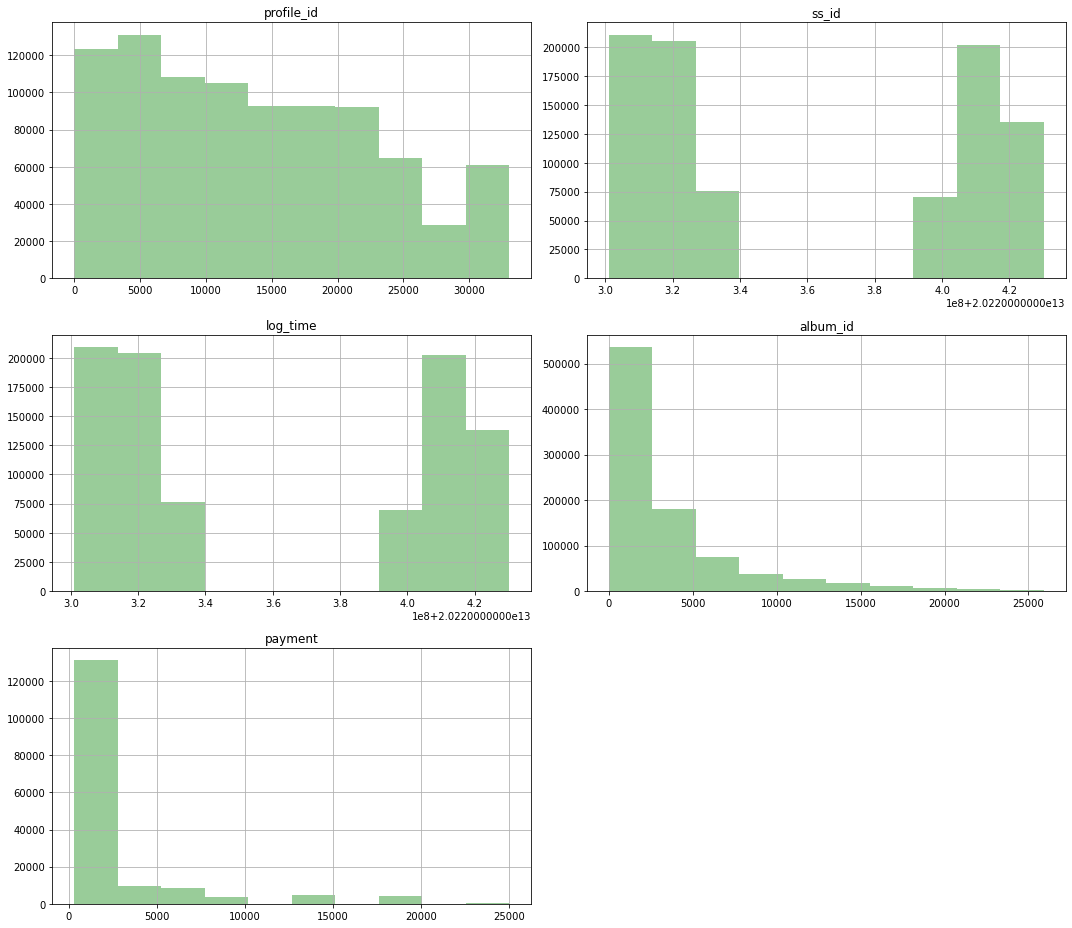

In [27]:
hd.hist(figsize = (15, 13), color = 'green', alpha = 0.4)
plt.tight_layout() # 그래프 간격 설정
plt.show()

<AxesSubplot:>

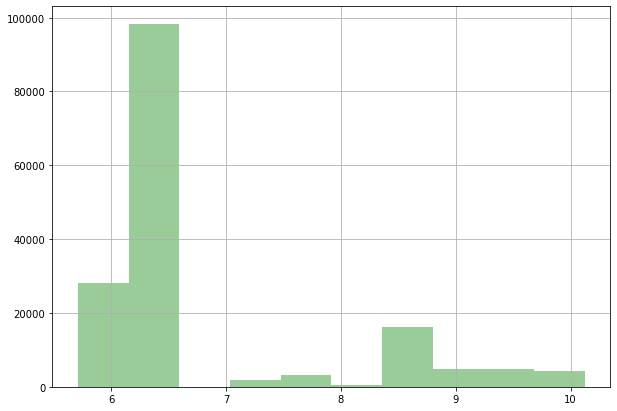

In [28]:
np.log1p(hd['payment']).hist(figsize = (10, 7), color = 'green', alpha = 0.4) # 로그변환

<AxesSubplot:>

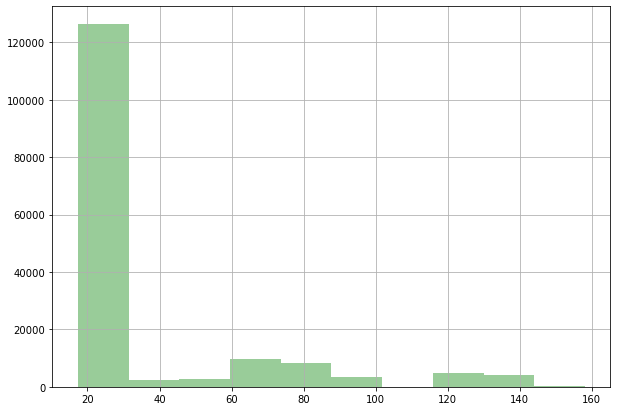

In [29]:
np.sqrt(hd['payment']).hist(figsize = (10, 7), color = 'green', alpha = 0.4) # sqrt변환

<AxesSubplot:>

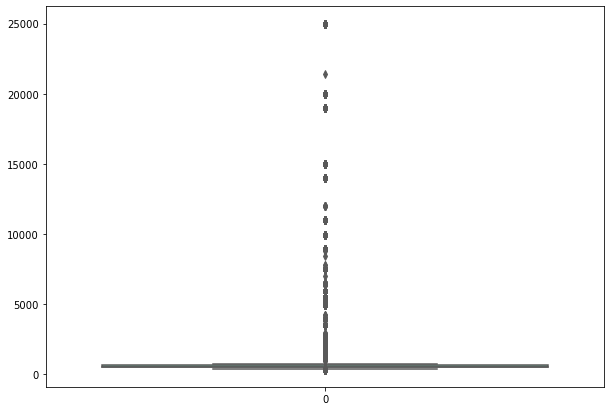

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,7))
sns.boxplot(data = hd['payment'], palette="Set2")

In [31]:
hd.describe()

,profile_id,ss_id,log_time,album_id,payment
count,899273.000000,8.992730e+05,8.992730e+05,899273.000000,161947.000000
mean,13689.012404,2.022036e+13,2.022036e+13,3327.891591,2199.735416
std,9005.148322,4.928843e+07,4.930476e+07,4208.573394,4204.011710
min,3.000000,2.022030e+13,2.022030e+13,0.000000,300.000000
25%,5888.000000,2.022031e+13,2.022032e+13,411.000000,500.000000
50%,12530.000000,2.022033e+13,2.022033e+13,2044.000000,500.000000
75%,20658.000000,2.022041e+13,2.022041e+13,4234.000000,616.666667
max,33032.000000,2.022043e+13,2.022043e+13,25916.000000,25000.000000


- 변수변환도 고려해보기!!!!!!!!!! (모든 컬럼)

In [32]:
# 다른방법 1 : 상위 80% 제거
hd2 = history.copy()

payment_cut = np.quantile(hd2['payment'], 0.8)
payment_cut

hd2 = hd2[hd2.loc[:,'payment'] < payment_cut]
#hd2['payment'].hist(figsize = (10, 7), color = 'green', alpha = 0.4)

- 위 방법 뭔가 이상함...... 왜 nan 뜨는지 모르겠음

In [33]:
# 다른방법 2 : LocalOutlierFactor 사용
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [34]:
hd3 = hd.copy()
hd3 = hd3.drop(['act_target_dtl', 'continuous_play', 'short_trailer'], axis = 1)
# 여기서 drop 해줬으므로 나중에 아래 컬럼 다시 붙여주어야함
# hd3+ = hd[['act_target_dtl', 'continuous_play', 'short_trailer']]

In [35]:
hd3

,profile_id,ss_id,log_time,album_id,payment
0,3,20220301115653,20220301115719,15,NaN
1,3,20220301115653,20220301115809,16,NaN
2,3,20220301115653,20220301115958,17,NaN
3,3,20220301115653,20220301120118,18,NaN
4,3,20220301115653,20220301120229,19,NaN
...,...,...,...,...,...
1005646,33032,20220427155091,20220427155668,381,5500.0
1005647,33032,20220427155091,20220427155680,381,5500.0
1005648,33032,20220427155839,20220427155810,125,NaN
1005649,33032,20220427155706,20220427155838,125,NaN


In [36]:
outlier = LocalOutlierFactor()

hd3["outlier"] = outlier.fit_predict(hd3.drop(["payment"], axis = 1)) 

In [37]:
#pd.plotting.scatter_matrix(hd3, c = hd3["outlier"])
#plt.show()
hd3 = hd3.drop(hd3[hd3["outlier"] == -1].index)

x_data = hd3.drop(["outlier", "payment"],axis=1).values
y_data = hd3["payment"].values

In [38]:
x_data.shape

(849011, 4)

In [39]:
y_data.shape

(849011,)

In [40]:
x_data = pd.DataFrame(x_data)

In [41]:
x_data

x_data = x_data.rename(columns = {x_data.columns[0] : 'profile_id', 
                                  x_data.columns[1] : 'ss_id',
                                  x_data.columns[2] : 'log_time',
                                  x_data.columns[3] : 'album_id'})

In [42]:
x_data

,profile_id,ss_id,log_time,album_id
0,3,20220301115653,20220301120118,18
1,3,20220301115653,20220301120229,19
2,3,20220301115653,20220301120450,20
3,3,20220301115653,20220301120654,21
4,3,20220301115653,20220301120859,22
...,...,...,...,...
849006,33032,20220427155091,20220427155668,381
849007,33032,20220427155091,20220427155680,381
849008,33032,20220427155839,20220427155810,125
849009,33032,20220427155706,20220427155838,125


In [43]:
y_data = pd.DataFrame(y_data)
y_data = y_data.rename(columns = {y_data.columns[0] : 'payment'})
y_data

,payment
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
849006,5500.0
849007,5500.0
849008,NaN
849009,NaN


In [44]:
outlier_hd = pd.concat([x_data, y_data], axis=1) 
outlier_hd

,profile_id,ss_id,log_time,album_id,payment
0,3,20220301115653,20220301120118,18,NaN
1,3,20220301115653,20220301120229,19,NaN
2,3,20220301115653,20220301120450,20,NaN
3,3,20220301115653,20220301120654,21,NaN
4,3,20220301115653,20220301120859,22,NaN
...,...,...,...,...,...
849006,33032,20220427155091,20220427155668,381,5500.0
849007,33032,20220427155091,20220427155680,381,5500.0
849008,33032,20220427155839,20220427155810,125,NaN
849009,33032,20220427155706,20220427155838,125,NaN


In [48]:
hd.columns

Index(['profile_id', 'ss_id', 'log_time', 'act_target_dtl', 'album_id',
       'payment', 'continuous_play', 'short_trailer'],
      dtype='object')

In [53]:
outlier_hd.columns

Index(['profile_id', 'ss_id', 'log_time', 'album_id', 'payment'], dtype='object')

In [54]:
hd3_ = hd[['profile_id', 'ss_id', 'log_time', 'act_target_dtl', 'album_id',
            'continuous_play', 'short_trailer']]
outlier_hd = pd.merge(outlier_hd, hd3_, on = ['profile_id', 'ss_id', 'log_time', 'album_id'], how = 'outer')

In [55]:
outlier_hd.isnull().sum().to_frame()

,0
profile_id,0
ss_id,0
log_time,0
album_id,0
payment,748830
act_target_dtl,0
continuous_play,0
short_trailer,0


In [56]:
outlier_hd

,profile_id,ss_id,log_time,album_id,payment,act_target_dtl,continuous_play,short_trailer
0,3,20220301115653,20220301120118,18,NaN,MKID003,Y,N
1,3,20220301115653,20220301120229,19,NaN,MKID003,Y,N
2,3,20220301115653,20220301120450,20,NaN,MKID003,Y,N
3,3,20220301115653,20220301120654,21,NaN,MKID003,Y,N
4,3,20220301115653,20220301120859,22,NaN,MKID003,Y,N
...,...,...,...,...,...,...,...,...
899300,33032,20220427112116,20220427143562,190,NaN,MKID003,Y,N
899301,33032,20220427112116,20220427144032,190,NaN,MKID003,N,N
899302,33032,20220427112116,20220427144126,125,NaN,MKID003,N,N
899303,33032,20220427112116,20220427144137,125,NaN,MKID003,Y,N


#### 4. 데이터 결합

#### 4-1. 필요없는 column drop ( hd : ss_id, wd : ss_id, log_time )

In [57]:
outlier_hd = outlier_hd.drop(["ss_id"], axis=1)
outlier_wd = outlier_wd.drop(["ss_id", "log_time"], axis=1)

In [58]:
outlier_hd.head()

,profile_id,log_time,album_id,payment,act_target_dtl,continuous_play,short_trailer
0,3,20220301120118,18,NaN,MKID003,Y,N
1,3,20220301120229,19,NaN,MKID003,Y,N
2,3,20220301120450,20,NaN,MKID003,Y,N
3,3,20220301120654,21,NaN,MKID003,Y,N
4,3,20220301120859,22,NaN,MKID003,Y,N


In [59]:
outlier_wd.head()

,profile_id,act_target_dtl,album_id,continuous_play,watch_time,total_time
0,3,MKID049,15,1,46,46
1,3,MKID049,16,1,104,105
2,3,MKID049,17,1,76,76
3,3,MKID049,18,1,67,68
4,3,MKID049,19,0,90,90


In [60]:
print('hd 데이터(행 삭제 완료) : ', outlier_hd.shape)
print('wd 데이터(행 삭제 완료) : ', outlier_wd.shape)

hd 데이터(행 삭제 완료) :  (899305, 7)
wd 데이터(행 삭제 완료) :  (767008, 6)


In [61]:
df_prc = pd.merge(outlier_hd, outlier_wd, on = ['profile_id', 'album_id'], how = 'outer')
df_prc # log time 제외

,profile_id,log_time,album_id,payment,act_target_dtl_x,continuous_play_x,short_trailer,act_target_dtl_y,continuous_play_y,watch_time,total_time
0,3,2.022030e+13,18,NaN,MKID003,Y,N,MKID049,1.0,67.0,68.0
1,3,2.022030e+13,19,NaN,MKID003,Y,N,MKID049,0.0,90.0,90.0
2,3,2.022030e+13,20,NaN,MKID003,Y,N,MKID049,1.0,119.0,119.0
3,3,2.022030e+13,20,NaN,MKID003,Y,N,MKID049,1.0,119.0,119.0
4,3,2.022030e+13,20,NaN,MKID003,Y,N,MKID049,1.0,119.0,119.0
...,...,...,...,...,...,...,...,...,...,...,...
10687976,33032,NaN,18334,NaN,NaN,NaN,NaN,MKID049,1.0,64.0,65.0
10687977,33032,NaN,18334,NaN,NaN,NaN,NaN,MKID049,0.0,1.0,74.0
10687978,33032,NaN,0,NaN,NaN,NaN,NaN,MKID049,0.0,3.0,136.0
10687979,33032,NaN,3128,NaN,NaN,NaN,NaN,MKID049,0.0,2.0,67.0
